In [31]:
from network_evaluation_tools import gene_conversion_tools as gct
from network_evaluation_tools import data_import_tools as dit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
wd = '/cellar/users/snwright/Data/Network_Analysis/'

# Version 2
## Load HINT Raw Data
#### Source: http://hint.yulab.org/download/HomoSapiens/binary/hq/ ; http://hint.yulab.org/download/HomoSapiens/cocomp/hq/
Downloaded: November 16, 2021
Last updated: August 2021. 
The two binary interactomes for High-Quality (HQ) and Co-Complex (CC) interactions were downloaded and merged into a single interactome for HINT.     
Citation: Das J and Yu H. HINT: High-quality protein interactomes and their applications in understanding human disease. BMC Systems Biology, 2012 Jul 30;6(1):92.

In [28]:
HINT_Bin_Raw_v2 = pd.read_csv(wd+'Network_Data_Raw/HINT/HomoSapiens_binary_hq.txt',sep='\t')
HINT_Com_Raw_v2 = pd.read_csv(wd+'Network_Data_Raw/HINT/HomoSapiens_cocomp_hq.txt',sep='\t')
print("Binary HQ:", len(HINT_Bin_Raw_v2))
print("Co-complex:", len(HINT_Com_Raw_v2))

Binary HQ: 126960
Co-complex: 188605


In [18]:
HINT_Raw_v2 = pd.concat([HINT_Bin_Raw_v2, HINT_Com_Raw_v2])
print('Concatenated list of edges:', HINT_Raw_v2.shape)
HINT_Raw_v2 = HINT_Raw_v2.drop_duplicates()
print('After duplicate edges removed:', HINT_Raw_v2.shape)

Concatenated list of edges: (315565, 9)
After duplicate edges removed: (315104, 9)


In [19]:
# Use UniProtID labels to annotate interactions
HPRD_Raw_Genes_Uniprot_v2 = set(HINT_Raw_v2['Uniprot_A']).union(set(HINT_Raw_v2['Uniprot_B']))

## Convert Genes from UniProt Accession ID to gene symbols

In [20]:
query_string_v2, valid_genes_v2, invalid_genes_v2 = gct.query_constructor(HPRD_Raw_Genes_Uniprot_v2)

17933 Valid Query Genes
0 Invalid Query Genes


In [21]:
# Set scopes (gene naming systems to search)
scopes = "uniprot"

# Set fields (systems from which to return gene names from)
fields = "symbol, entrezgene"

# Query MyGene.Info
match_list_v2 = gct.query_batch(query_string_v2, scopes=scopes, fields=fields)
print(len(match_list_v2), 'Matched query results')

100%|██████████| 18/18 [00:12<00:00,  1.46it/s]

18212 Matched query results
Batch query complete: 12.36 seconds
18212 Matched query results


In [22]:
match_table_trim_v2, query_to_symbol_v2, query_to_entrez_v2 = gct.construct_query_map_table(match_list_v2, valid_genes_v2)

Queries without full matching results found: 1110

198 Queries with mutliple matches found

Query mapping table/dictionary construction complete: 8.27 seconds


## Construct Converted Network

In [23]:
HINT_edgelist_v2 = HINT_Raw_v2[['Uniprot_A', 'Uniprot_B']].values.tolist()

In [24]:
# Convert edge list
HINT_edgelist_symbol_v2 = gct.convert_edgelist(HINT_edgelist_v2, query_to_symbol_v2, weighted=False)

In [25]:
# Filter edge list
HINT_edgelist_symbol_filt_v2 = gct.filter_converted_edgelist(HINT_edgelist_symbol_v2)

315104 input edges
6193 self-edges removed
5809 edges with un-mapped genes removed
16661 duplicate edges removed
Edge list filtered: 0.11 seconds
286441 Edges remaining


In [26]:
# Save edge list
gct.write_edgelist(HINT_edgelist_symbol_filt_v2, wd+'Processed_Data/Network_SIFs_Symbol/HINT_Symbol_2021.sif')

Edge list saved: 0.26 seconds


# Version 1
## Load HINT Raw Data
#### Source: http://hint.yulab.org/batch.html
Downloaded: June 15, 2017  
Last update not listed, but currently on version 4 (updated early 2017). The two binary interactomes for High-Quality (HQ) and Co-Complex (CC) interactions were downloaded and merged into a single interactome for HINT.     
Citation: Das J and Yu H. HINT: High-quality protein interactomes and their applications in understanding human disease. BMC Systems Biology, 2012 Jul 30;6(1):92.

#### Note on 2021 re-run: the number of matched genes has changed slightly due to updated/changed gene identifiers


In [29]:
HINT_Bin_Raw = pd.read_csv(wd+'Network_Data_Raw/HINT/HINT_v4_binary_HomoSapiens.txt',sep='\t')
HINT_Com_Raw = pd.read_csv(wd+'Network_Data_Raw/HINT/HINT_v4_complex_HomoSapiens.txt',sep='\t')
print("Binary HQ:", len(HINT_Bin_Raw))
print("Co-complex:", len(HINT_Com_Raw))

Binary HQ: 59128
Co-complex: 122571


In [5]:
HINT_Raw = pd.concat([HINT_Bin_Raw, HINT_Com_Raw])
print('Concatenated list of edges:', HINT_Raw.shape)
HINT_Raw = HINT_Raw.drop_duplicates()
print('After duplicate edges removed:', HINT_Raw.shape)

Concatenated list of edges: (181699, 9)
After duplicate edges removed: (181375, 9)


In [6]:
# Use UniProtID labels to annotate interactions
HPRD_Raw_Genes_Uniprot = set(HINT_Raw['Uniprot_A']).union(set(HINT_Raw['Uniprot_B']))

## Convert Genes from UniProt Accession ID to gene symbols

In [7]:
query_string, valid_genes, invalid_genes = gct.query_constructor(HPRD_Raw_Genes_Uniprot)

15784 Valid Query Genes
0 Invalid Query Genes


In [9]:
# Set scopes (gene naming systems to search)
scopes = "uniprot"

# Set fields (systems from which to return gene names from)
fields = "symbol, entrezgene"

# Query MyGene.Info
match_list = gct.query_batch(query_string, scopes=scopes, fields=fields)
print(len(match_list), 'Matched query results')

100%|██████████| 16/16 [00:11<00:00,  1.39it/s]

15974 Matched query results
Batch query complete: 11.57 seconds
15974 Matched query results


In [10]:
match_table_trim, query_to_symbol, query_to_entrez = gct.construct_query_map_table(match_list, valid_genes)

Queries without full matching results found: 732

144 Queries with mutliple matches found

Query mapping table/dictionary construction complete: 6.41 seconds


## Construct Converted Network

In [11]:
HINT_edgelist = HINT_Raw[['Uniprot_A', 'Uniprot_B']].values.tolist()

In [12]:
# Convert edge list
HINT_edgelist_symbol = gct.convert_edgelist(HINT_edgelist, query_to_symbol, weighted=False)

In [13]:
# Filter edge list
HINT_edgelist_symbol_filt = gct.filter_converted_edgelist(HINT_edgelist_symbol)

181375 input edges
4568 self-edges removed
4313 edges with un-mapped genes removed
13822 duplicate edges removed
Edge list filtered: 0.06 seconds
158672 Edges remaining


In [15]:
# Save edge list
gct.write_edgelist(HINT_edgelist_symbol_filt, wd+'Processed_Data/Network_SIFs_Symbol/HINT_Symbol_v4_2017.sif')

Edge list saved: 0.15 seconds


# Changes

In [30]:

stats = pd.DataFrame({"v1":[59128, 122571, 181375, 158672], 
                           "v2":[126960, 188605, 315104, 286441]},
                           index=["Binary input", "Co-complex input", "Combined", "Filtered"])

In [32]:
nodes_v1 = set(HINT_edgelist_symbol_filt["symbol_n1"].values).union(set(HINT_edgelist_symbol_filt["symbol_n2"].values))
nodes_v2 = set(HINT_edgelist_symbol_filt_v2["symbol_n1"].values).union(set(HINT_edgelist_symbol_filt_v2["symbol_n2"].values))

Text(0, 0.5, 'Number of nodes')

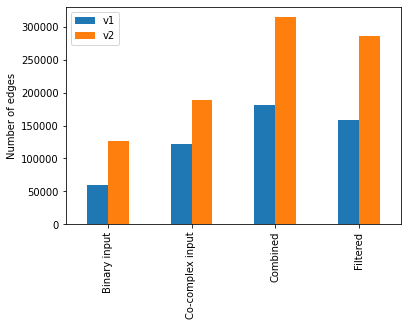

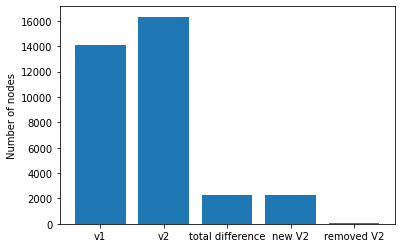

In [33]:
stats.plot.bar(ylabel="Number of edges")
plt.figure()
plt.bar(["v1", "v2", "total difference", "new V2", "removed V2"], [len(nodes_v1), len(nodes_v2), len(nodes_v2)-len(nodes_v1),
                                                           len(nodes_v2.difference(nodes_v1)), len(nodes_v1.difference(nodes_v2))])
plt.ylabel("Number of nodes")